In [4]:
# 📘 1. 라이브러리 불러오기
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 📁 2. 전처리 완료된 CCTV 데이터 불러오기
df = pd.read_csv("../../data/processed_cctv.csv", encoding="cp949")

# ✅ 데이터 확인
print("✅ 데이터 로드 완료. 행 수:", len(df))
df.head()

✅ 데이터 로드 완료. 행 수: 4091


,자치구,안심 주소,위도,경도,CCTV 수량,수정 일시,시설유형,구역코드,세부번호,cluster
0,광진구,공원-광장-045-01,37.5460,127.1039,1,2022-12-01,공원-광장,45.0,01,0
1,광진구,공원-광장-045-02,37.5460,127.1039,1,2022-12-01,공원-광장,45.0,02,0
2,광진구,공원-광장-045-03,37.5460,127.1039,1,2022-12-01,공원-광장,45.0,03,0
3,광진구,공원-광장-045-비상벨,37.5460,127.1039,1,2022-12-01,공원-광장,45.0,비상벨,0
4,광진구,공원-광장-046-01,37.5482,127.1006,1,2022-12-01,공원-광장,46.0,01,0


📌 구역별 CCTV 수량 요약:
      구역코드  CCTV 수량
8      9.0       17
7      8.0       16
5      6.0       13
3      4.0       13
4      5.0       13
..     ...      ...
33    36.0        1
29    32.0        1
47    56.0        1
23    25.0        1
133  328.0        1

[221 rows x 2 columns]


/tmp/ipykernel_149994/3245740381.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=df_grouped, x='구역코드', y='CCTV 수량', palette='Blues_d')
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.

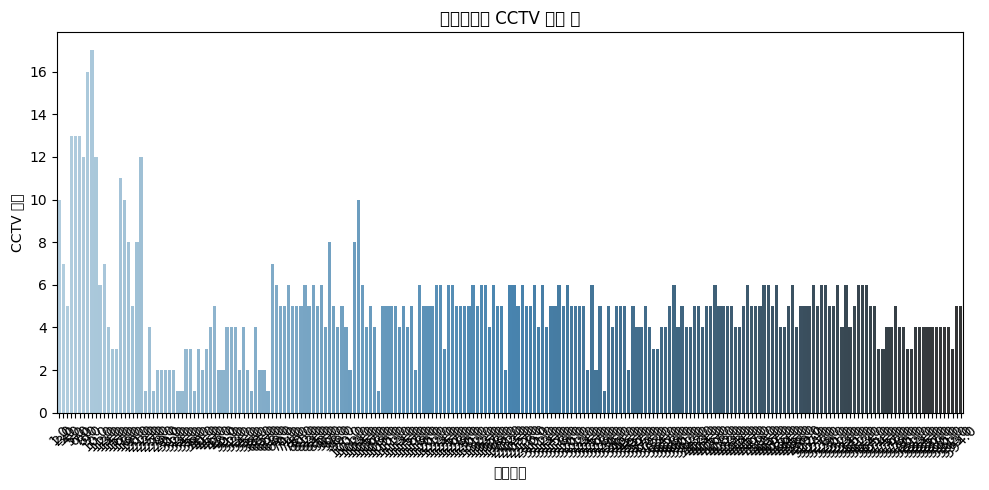

In [7]:
import matplotlib.font_manager as fm
# 나눔고딕 폰트 경로 불러오기
font_path = "/usr/share/fonts/truetype/nanum/NanumGothic.ttf"
fontprop = fm.FontProperties(fname=font_path)

# 기본 폰트로 설정
plt.rcParams['font.family'] = fontprop.get_name()
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 깨짐 방지

df_grouped = df.groupby('구역코드')['CCTV 수량'].sum().reset_index().sort_values(by='CCTV 수량', ascending=False)
print("📌 구역별 CCTV 수량 요약:")
print(df_grouped)

# 시각화 (막대그래프)
plt.figure(figsize=(10, 5))
sns.barplot(data=df_grouped, x='구역코드', y='CCTV 수량', palette='Blues_d')
plt.title("구역코드별 CCTV 설치 수")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()